# Práctica final NLP - Top Modeling

## Datasets

Los datasets escogidos para los distintos ejercicios son los siguientes:
- **Reviews de Amazon**: Reviews de productos de Amazon clasificadas por categorías (libros, electrónica, automoción, ...). Las reviews contienen la calificación (número de estrellas) por lo que es perfecto para problemas de clasificación supervisada del sentimiento. Se recomienda trabajar con subsets de dichos datasets para evitar problemas de memoria y de desbalanceo de clases. Enlace: http://jmcauley.ucsd.edu/data/amazon/
- **Tweets**: Conjunto de tweets de diferentes personalidades. Los tweets están en crudo, esto es, contendrán enlaces, menciones, hashtags que convendrá normalizar u eliminar. Enlace: https://www.kaggle.com/speckledpingu/RawTwitterFeeds

##  Consideraciones

Como se comentaba, por delante del performance de los distintos modelos que se prueben, se valorará positivamante para todos los ejercicios:

- Análisis exploratorio y descripción de las variables escogidas
- Argumentación del modelo (o modelos) escogidos, así como de las etapas implementadas en el preprocesado
- Comparativa de resultados modificando alguna etapa en el preprocesado, probando diferentes modelos, etc
- Conclusiones
- Retos superados y limitaciones

# Ejercicio 1. Modelado de Topics

El objetivo principal de este ejercicio es el de realizar un **análisis exploratorio** - etapa principal en cualquier problema de analítica, ML, DL y, por supuesto, NLP - de alguno de los datasets disponibles (tweets o reviews de Amazon).

Además del análisis exploratorio, se pide que el alumno realice un **modelado de topics** identificando los principales temas que aparecen en los corpus, así como los tokens que los componen.

Será muy valorable si se incluyen **gráficos descriptivos** que describan los corpus utilizados.

Se recomienda, aunque no es obligatorio, utilizar los datasets de las reviews de Amazon y que este ejercicio sea la _antesala_ del ejercicio 2.


Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts

# Importar librerías

In [2]:
import os
import random
import pandas as pd
from num2words import num2words

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

# Cargamos los datos

Hemos elegir 5 categorias para realizar el estudio de los topics : baby, beauty, food, musical instruments and sports & outdoors.

In [3]:
df_Baby = pd.read_json('Baby_5.json', lines=True)
df_Beauty = pd.read_json('Beauty_5.json', lines=True)
df_Food = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)
df_Musical_Instruments = pd.read_json('Musical_Instruments_5.json', lines=True)
df_Sports_and_Outdoors = pd.read_json('Sports_and_Outdoors_5.json', lines=True)

In [4]:
df_Baby['reviewText'][0]

"Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!"

In [6]:
df_Baby.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"


In [7]:
df_Baby.dropna(inplace=True)
df_Beauty.dropna(inplace=True)
df_Food.dropna(inplace=True)
df_Musical_Instruments.dropna(inplace=True)
df_Sports_and_Outdoors.dropna(inplace=True)

df_Baby = df_Baby[['reviewText']][0:2000]
df_Beauty = df_Beauty[['reviewText']][0:2000]
df_Food = df_Food[['reviewText']][0:2000]
df_Musical_Instruments = df_Musical_Instruments[['reviewText']][0:2000]
df_Sports_and_Outdoors = df_Sports_and_Outdoors[['reviewText']][0:2000]


In [8]:
# Juntamos todos los dataframes de las 5 categorías en un solo dataframe

dfs = [df_Baby, df_Beauty, df_Food,  df_Musical_Instruments, df_Sports_and_Outdoors]
df_Total = pd.concat(dfs)

In [9]:
df_Total.head()

,reviewText
0,Perfect for new parents. We were able to keep ...
1,This book is such a life saver. It has been s...
2,Helps me know exactly how my babies day has go...
3,I bought this a few times for my older son and...
4,I wanted an alternative to printing out daily ...


# Prepocesado

Vamos a realizar 3 pasos principalmente: 
- Tokenización - cortar las cadenas en trozos de texto más pequeños, "tokens". En nuestro caso vamos a usar palabras.
- Normalization - Consiste en procesar el texto para que pueda ser procesado después por el modelo. Esto incluye, converter a minúscula/mayúscula, eliminar puntuación (esto podría indicarnos el final de frase, pero no nos aporta información adiccional sobre el contenido), convertir números a sus equivalentes palabras, lemmatizar(transformación de las palabras para quedarnos con la forma canónica de la palabra),eliminar espacios en blanco extra, eliminar stopwords (son las palabras que no contribuyen mucho al significado del texto, ya que tiene una frecuencia de aparición grande y eliminar sparse terms( ignorar términos que tienen una frecuencia muy baja - 1,2,3,5,10 veces - para poder realizar una mejor generalización y evitar overfitting.
- Noise removal, depende del framework de donde obtengamos nuestro corpus. Si tiene etiquetas HTML/XML , headers, extraer inforrmación de ficheros json o bases de datos, y expresiones regulares( por ejemplo eliminación de URL) .


En nuestro caso, primero hemos extraido la información del fichero .json a un dataframe de pandas. 
Ahora vamos a proceder a tokenizar y normalizar. 

Creamos varias funciones para realizar el preprocesado.

- La primera es para eliminar URLs.
- La segunda función es para lemmatizar los tokens. 
- La tercera es para separar cada token, en nuestro caso cada palabra del párrafo review, eliminando puntuación. Además confirmamos si hay números y los pasamos a letra y lemmatizamos. Para el caso del procesado he decicido eliminar palabras con menos de 2 caracteres de longitud, ya que este tipo de palabras están asociadas a preposiciones y determinantes.
- La cuarta para juntar todas las listas de palabras en una lista.  

Nota I: Uso las funciones de Carlos :)     
Nota II : Fichero de lemmatización obtenido de https://github.com/michmech/lemmatization-list

In [11]:
# Función para eliminar URLs
def URL_removal(text):
    text = re.sub(r'http\S+', '', text)
    return text

# Función para lemmatizar las palabra. Necesitamos proporcionarle el fichero de lemmatización  
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

# Convierte a minúsuclas, tokeniza y elimina palabras de 2 o menos carácteres
# la salida son tokens - cadenas unicode que no necesitan más procesado
def text_preproc(text):
    
    data_path = './'
    lemmas_dict_file = 'lemmatization-en.txt'
    lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)    
    
    result=[]
   
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            if token.isdigit():
                token = num2words(token, lang='en')
            ltoken = lemmas_dict.get(token, token)
            result.append(ltoken)
    return result

# Esta función crea una lista de listas de tokens, cada sublista pertenece a un registro del dataframe
def all_text(l):
    texts = []
    for text in l:
        texts.append(text_preproc(text))
    return texts


In [14]:
# Eliminamos primero URLs en el dataset
df_Total['reviewText'] = df_Total['reviewText'].apply(URL_removal)

In [15]:
# Aplicar el preprocesado al dataset
words_text = all_text(df_Total['reviewText'])

In [16]:
# verificamos el contenido de la lista de listas. 
print(words_text[0:5])

[['perfect', 'new', 'parent', 'able', 'track', 'baby', 'feed', 'sleep', 'diaper', 'change', 'schedule', 'half', 'month', 'life', 'life', 'easy', 'doctor', 'ask', 'question', 'habit', 'right'], ['book', 'life', 'saver', 'helpful', 'able', 'track', 'trend', 'answer', 'pediatrician', 'question', 'communicate', 'different', 'time', 'night', 'newborn', 'think', 'thing', 'require', 'leave', 'hospital', 'go', 'page', 'newborn', 'version', 'move', 'infant', 'version', 'finish', '2', 'infant', 'book', 'total', 'right', 'baby', 'turn', 'thing', 'haves', 'baby'], ['help', 'know', 'exactly', 'baby', 'day', 'go', 'mother', 'law', 'watch', 'work', 'section', 'write', 'note', 'let', 'know', 'need', 'couldn', 'happy', 'book'], ['buy', 'time', 'old', 'son', 'buy', 'newborn', 'super', 'easy', 'use', 'help', 'track', 'daily', 'routine', 'start', 'go', 'sitter', 'go', 'work', 'help', 'know', 'day', 'go', 'well', 'prepare', 'even', 'likely', 'sick', 'help', 'track', 'diaper', 'day', 'produce', 'sure', 'get

# Visualización de palabras
 
Para crear un wordcloud, necesitamos pasarle a la función una única lista de tokens.

In [17]:
# Convertimos word_text a string
full_str = ('\n'.join(' '.join(sub) for sub in words_text))
li = list(full_str.split(' '))

In [26]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=70, max_words=500, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(14,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

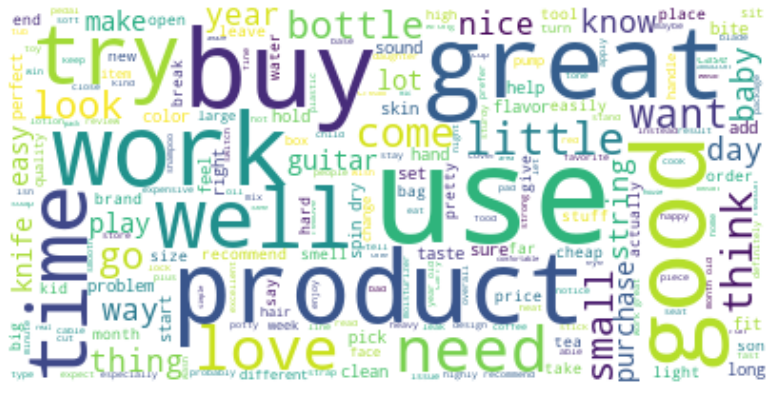

In [27]:
plot_word_cloud(li)

# Diccionario

Creamos un dictionario con las palabras del corpus que tenemos. Este diccionario contiene los tokens con su correspondiente ID. 

In [29]:
# Creamos el diccionario
dict_text = Dictionary(words_text)

In [30]:
# Verificamoso que se ha formado
list(dict_text.items())

[(0, 'able'),
 (1, 'ask'),
 (2, 'baby'),
 (3, 'change'),
 (4, 'diaper'),
 (5, 'doctor'),
 (6, 'easy'),
 (7, 'feed'),
 (8, 'habit'),
 (9, 'half'),
 (10, 'life'),
 (11, 'month'),
 (12, 'new'),
 (13, 'parent'),
 (14, 'perfect'),
 (15, 'question'),
 (16, 'right'),
 (17, 'schedule'),
 (18, 'sleep'),
 (19, 'track'),
 (20, '2'),
 (21, 'answer'),
 (22, 'book'),
 (23, 'communicate'),
 (24, 'different'),
 (25, 'finish'),
 (26, 'go'),
 (27, 'haves'),
 (28, 'helpful'),
 (29, 'hospital'),
 (30, 'infant'),
 (31, 'leave'),
 (32, 'move'),
 (33, 'newborn'),
 (34, 'night'),
 (35, 'page'),
 (36, 'pediatrician'),
 (37, 'require'),
 (38, 'saver'),
 (39, 'thing'),
 (40, 'think'),
 (41, 'time'),
 (42, 'total'),
 (43, 'trend'),
 (44, 'turn'),
 (45, 'version'),
 (46, 'couldn'),
 (47, 'day'),
 (48, 'exactly'),
 (49, 'happy'),
 (50, 'help'),
 (51, 'know'),
 (52, 'law'),
 (53, 'let'),
 (54, 'mother'),
 (55, 'need'),
 (56, 'note'),
 (57, 'section'),
 (58, 'watch'),
 (59, 'work'),
 (60, 'write'),
 (61, 'buy'),
 (62

In [31]:
print(f'La longitud del vocabulario consta de:', len(dict_text) ,'palabras')

La longitud del vocabulario consta de: 15734 palabras


# Bag of words

Creamos el bag of words usando el diccionario. Esto genera una estructura donde tenemos el ID de la palabra junto a la frecuencia de repetición en el corpus(doc2bow).
Esta ejecución tien efectos de vectorizar el *doc* - cada documento en el corpus- y creando lo que se llama también la matriz de documentos-palabras.  
Hay que tener en cuenta que no se codifica información relativa a la posición de los tokens en el corpus.

In [32]:
# Creamos el corpus. Cramos un dicionaro para cada document
# Este diccionario contiene el número de palabra y su frecuencia de repetición
corpus = [dict_text.doc2bow(doc) for doc in words_text]

In [33]:
# Verificamos el contenido
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [34]:
#Creamos el diccionario que contiene cada palabra y la frecuencia de repetición
word_freq = [[(dict_text[id], frequence) for id, frequence in couple] for couple in corpus]
print(word_freq[0:2])

[[('able', 1), ('ask', 1), ('baby', 1), ('change', 1), ('diaper', 1), ('doctor', 1), ('easy', 1), ('feed', 1), ('habit', 1), ('half', 1), ('life', 2), ('month', 1), ('new', 1), ('parent', 1), ('perfect', 1), ('question', 1), ('right', 1), ('schedule', 1), ('sleep', 1), ('track', 1)], [('able', 1), ('baby', 2), ('life', 1), ('question', 1), ('right', 1), ('track', 1), ('2', 1), ('answer', 1), ('book', 2), ('communicate', 1), ('different', 1), ('finish', 1), ('go', 1), ('haves', 1), ('helpful', 1), ('hospital', 1), ('infant', 2), ('leave', 1), ('move', 1), ('newborn', 2), ('night', 1), ('page', 1), ('pediatrician', 1), ('require', 1), ('saver', 1), ('thing', 2), ('think', 1), ('time', 1), ('total', 1), ('trend', 1), ('turn', 1), ('version', 2)]]


# Visualizar las 20 palabras con más frecuencia

In [42]:
# Codigo from : https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# Usando la función counvectorizer. Esta fuunción permite transformar el texto en tokens y 
# convertirlo en un vector de términos. 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
sns.set_style('whitegrid')
%matplotlib inline

def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 10))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

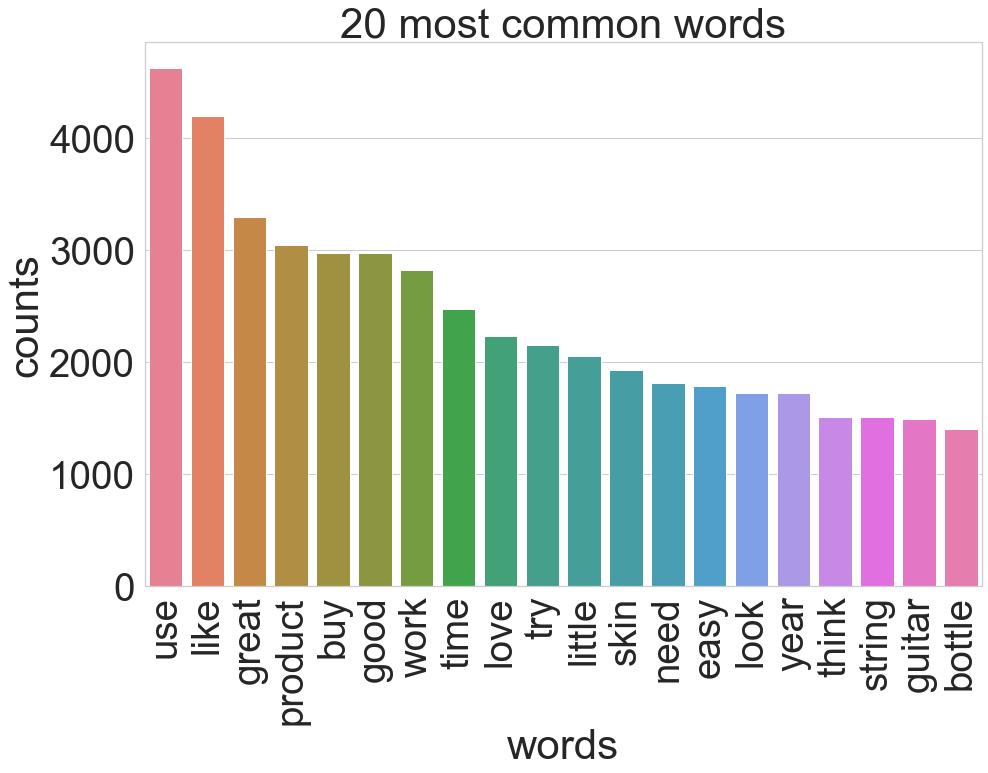

In [43]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(li)

# Visualise the 20 most common words
plot_20_most_common_words(count_data, count_vectorizer)

Hasta aqui, hemos visto que el procesamiento del texto es importante para crear un diccionario con el que vamos a desplegar los modelos.

# Entrenamos modelo LDA

Usamos LDA (Latent Dirichlet Allocation), modelo probabilistico que se puede explicar es sus tres términos: 
- Latent: hace referencia a todo lo que no conocemos a priori y está escondido en los datos. Es decir los temas/topics.
- Dirichlet: es una 'distribution of distributions'. Se puede definir como que Dirichlet es la distribución de topics en documents y distrución de palabras en el topic. 
- Allocation: Una vez tenemos Dirichlet, asignamos topics a los documents y palabras del document a los topics. 

De tal forma que LDA nos ayuda a crear clusters de palabras para crear topics, y clusters de documents para crear mezcla de topics. 

## Para número de topics = 5

In [46]:
num_topics = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=dict_text,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [47]:
lda_model.show_topics()

[(0,
  '0.010*"use" + 0.009*"add" + 0.007*"flavor" + 0.007*"band" + 0.006*"like" + 0.006*"sauce" + 0.006*"cook" + 0.005*"well" + 0.005*"honey" + 0.005*"salt"'),
 (1,
  '0.014*"guitar" + 0.014*"string" + 0.013*"sound" + 0.010*"work" + 0.009*"great" + 0.008*"bottle" + 0.008*"set" + 0.007*"play" + 0.007*"get" + 0.007*"need"'),
 (2,
  '0.017*"like" + 0.016*"great" + 0.016*"easy" + 0.015*"love" + 0.014*"use" + 0.012*"pick" + 0.011*"little" + 0.010*"year" + 0.009*"buy" + 0.008*"fit"'),
 (3,
  '0.022*"knife" + 0.021*"use" + 0.019*"product" + 0.017*"skin" + 0.011*"like" + 0.011*"work" + 0.010*"feel" + 0.009*"hair" + 0.008*"blade" + 0.008*"color"'),
 (4,
  '0.022*"good" + 0.019*"buy" + 0.016*"well" + 0.014*"like" + 0.013*"price" + 0.013*"tea" + 0.010*"product" + 0.010*"taste" + 0.009*"great" + 0.008*"amazon"')]

In [48]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05
0,use,guitar,like,knife,good
1,add,string,great,use,buy
2,flavor,sound,easy,product,well
3,band,work,love,skin,like
4,like,great,use,like,price
5,sauce,bottle,pick,work,tea
6,cook,set,little,feel,product
7,well,play,year,hair,taste
8,honey,get,buy,blade,great
9,salt,need,fit,color,amazon


In [49]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_text , dictionary=dict_text, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.546802882211812

Coherence Score:  0.36645870088689


## Visualización

In [52]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dict_text)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.123634  0.091640       1        1  24.959990
3      0.002151 -0.205993       2        1  21.979881
2      0.146768  0.028529       3        1  21.552256
4     -0.067083  0.018502       4        1  18.780094
0     -0.205470  0.067323       5        1  12.727780, topic_info=              Term         Freq        Total Category  logprob  loglift
2432         knife  1977.000000  1977.000000  Default  30.0000  30.0000
2034          skin  1414.000000  1414.000000  Default  29.0000  29.0000
5888           tea   893.000000   893.000000  Default  28.0000  28.0000
766         string  1787.000000  1787.000000  Default  27.0000  27.0000
11563       guitar  1769.000000  1769.000000  Default  26.0000  26.0000
630          sound  1288.000000  1288.000000  Default  25.0000  25.0000
468           pick  1043.000000  1043.000000  Default  24.0000  24.0000
6             easy  1661.000000  1661.000000  Default  23.0000  23.0000
2579          hair   772.000000   772.000000  Default  22.0000  22.0000
572        product  2599.000000  2599.000000  Default  21.0000  21.0000
5121         taste   918.000000   918.000000  Default  20.0000  20.0000
2575          soap   658.000000   658.000000  Default  19.0000  19.0000
279           good  3116.000000  3116.000000  Default  18.0000  18.0000
61             buy  2880.000000  2880.000000  Default  17.0000  17.0000
1382         blade   718.000000   718.000000  Default  16.0000  16.0000
1140        amazon   615.000000   615.000000  Default  15.0000  15.0000
4331        coffee   584.000000   584.000000  Default  14.0000  14.0000
835           face   604.000000   604.000000  Default  13.0000  13.0000
705          price  1471.000000  1471.000000  Default  12.0000  12.0000
304           play  1103.000000  1103.000000  Default  11.0000  11.0000
1012          wash   596.000000   596.000000  Default  10.0000  10.0000
153           love  1948.000000  1948.000000  Default   9.0000   9.0000
5184        flavor   684.000000   684.000000  Default   8.0000   8.0000
510            add   675.000000   675.000000  Default   7.0000   7.0000
333           feel  1345.000000  1345.000000  Default   6.0000   6.0000
1041           fit   966.000000   966.000000  Default   5.0000   5.0000
11564        pedal   601.000000   601.000000  Default   4.0000   4.0000
829           ball   471.000000   471.000000  Default   3.0000   3.0000
1158          lock   708.000000   708.000000  Default   2.0000   2.0000
1223         potty   457.000000   457.000000  Default   1.0000   1.0000
1097      mattress   194.780624   195.882690   Topic1  -6.1675   1.3823
2535        nipple   131.778366   132.619507   Topic1  -6.5582   1.3815
211           pump   416.162933   419.178955   Topic1  -5.4083   1.3807
608            amp   303.300415   306.168182   Topic1  -5.7246   1.3785
3646         avent    78.857048    79.653503   Topic1  -7.0717   1.3778
2905    instrument   218.275024   220.986099   Topic1  -6.0536   1.3756
4137         valve    59.625935    60.405907   Topic1  -7.3512   1.3749
1541          plug   168.614655   170.913330   Topic1  -6.3117   1.3744
1319         noise   166.600784   168.892517   Topic1  -6.3237   1.3742
2182    electronic    59.548206    60.467808   Topic1  -7.3525   1.3726
3511         setup    55.216873    56.084045   Topic1  -7.4281   1.3723
3628          flow    57.487705    58.416515   Topic1  -7.3878   1.3719
11597          xlr    50.580776    51.411865   Topic1  -7.5158   1.3716
2914       speaker    47.767315    48.553101   Topic1  -7.5730   1.3716
2946          tune   200.406097   203.718170   Topic1  -6.1390   1.3715
2765          bolt    48.879631    49.718758   Topic1  -7.5500   1.3709
729            tie    58.020363    59.068977   Topic1  -7.3785   1.3700
714          quiet    56.653366    57.782562   Topic1  -7.4024   1.3682
653        battery   236.227142   241.107849   Topi

In [53]:
pyLDAvis.save_html(vis, './topics5_vis.htmml')

La interpretabiliad de los topic no es un trabajo sencillo. Si nos fijamos en la tabla de palabras para los 5 topics, llego a las siguientes conclusiones (opinión pedida a persona ajena al proyecto :) ):

- Topic# 1 - Música
- Topic# 2 - Aseo
- Topic# 3 - Me cuesta identificar
- Topic# 4 - Comercio electrónico - tienda online
- Topic# 5 - Comida

Cuando digo 'Me cuesta identificar' es que leo las palabras y no me viene un topic que pueda englobar todas las palabras, porque hay mucha variabilidad. 
Una forma popular de ayudarnos con esto, es la visualizacion con pyLDAvis.    
Con esta visualización en dos dimensiones, reducimos dimensionalidad a costa de perder información, y puede que aunque dos circulos parezcan estar muy juntos, a medida que fuésemos añadiendo más dimensiones, podrían realmente estar muy lejos. 

- Los círculos representan la dimensión de los topics. A mayor radio, más número de palabras forman ese topic, por lo que indica la relevancia en el corpus.    
- Cuando los círculos se solapan, nos indica que comparten varias palabras.    
- Círculos próximos indican topics similares. 
- Cuando se selecciona un topic, se puede ver el porcentaje de cada token para ese topic. Podemos usar esta medida como descartar topics irrelevantes.
- Cuando pasamos el ratón por encima de una palabra, podemos visualizar el cambio de tamaño de los círculos, indicando la importancia de ese token para cada uno de los tokens. 

Aunque no hemos conseguido extraer un topic representable para el topic 3, si veo como hay palabras que se repiten en el topic 1 y 3, por lo que tienen sentido cierta cercanía. 
Para el topic 5, vemos que los terminos que aparecen son bastante exclusivos de este topic, por lo que podriamos tener bastante confianza a la hora de definir este topic. No pasa lo mismo con el resto. 

Sobre el valor de lambda: 
- Left lambda = 0, muestra cuánto de exclusivo es un token en un topic . 
El ranking del token está basado puramente en P(word | topic)
- Right lambda = 1, muestra cuánto es de probable que un token aparezca en un topic.
El ranking del token está basado en P(word | topic) / P(word)

De esta forma podemos determinar tokens que pertenezcan exclusivamente a un topic, lo que nos debería ayudar a diferenciar entre tokens. 
Veo que este ajuste es especialmente útil para tener una ídea más proxima de topic a un conjunto de palabras, y por ejemplo en el caso del topic# 3, si llevo lambda a 0, veo más palabras que tienen relación con sports & outdoors. 

A modo de curiosidad la palabra 'use' aparece en todos los topics! 

## Tunear hyperparámetros

Vamos a entrenar el módelo para varios números de topics y ver cuál es el número que elige.

In [59]:
def compute_coherence_values(dictionary, corpus, texts):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(2, 10, 1):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
model_list, coherence_values = compute_coherence_values(
    dictionary =dict_text,
    corpus=corpus,
    texts=words_text,
)

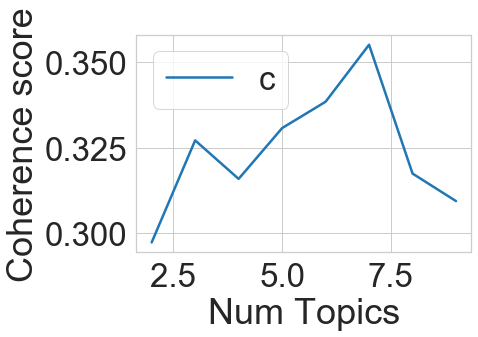

In [63]:
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Observamos que los valores de coherencia más alto se dan para 5, 6 y 7.      
Vamos a entrenar el modelo de nuevo para el valor más alto que corresponde a 7.

## Para número de topics = 7

In [88]:
num_topics = 7

lda_model7 = LdaModel(
    corpus=corpus,
    id2word=dict_text,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [89]:
lda_model7.show_topics()

[(0,
  '0.034*"knife" + 0.016*"tool" + 0.014*"use" + 0.012*"blade" + 0.009*"small" + 0.009*"work" + 0.008*"need" + 0.008*"band" + 0.008*"carry" + 0.007*"pocket"'),
 (1,
  '0.031*"string" + 0.031*"guitar" + 0.022*"sound" + 0.019*"play" + 0.017*"pick" + 0.011*"great" + 0.010*"like" + 0.009*"pedal" + 0.009*"set" + 0.008*"use"'),
 (2,
  '0.034*"product" + 0.028*"skin" + 0.028*"use" + 0.014*"hair" + 0.013*"soap" + 0.013*"feel" + 0.013*"smell" + 0.012*"clean" + 0.012*"face" + 0.012*"wash"'),
 (3,
  '0.021*"taste" + 0.019*"tea" + 0.016*"flavor" + 0.012*"like" + 0.009*"add" + 0.008*"well" + 0.008*"use" + 0.007*"food" + 0.007*"honey" + 0.007*"product"'),
 (4,
  '0.025*"bottle" + 0.017*"coffee" + 0.013*"hot" + 0.012*"water" + 0.010*"store" + 0.009*"cup" + 0.009*"use" + 0.008*"heat" + 0.007*"bag" + 0.007*"filter"'),
 (5,
  '0.019*"easy" + 0.014*"use" + 0.011*"fit" + 0.011*"lock" + 0.010*"old" + 0.009*"love" + 0.009*"baby" + 0.008*"cable" + 0.008*"hold" + 0.008*"kid"'),
 (6,
  '0.030*"good" + 0.02

In [90]:
word_dict = {};
for i in range(num_topics):
    words = lda_model7.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,knife,string,product,taste,bottle,easy,good
1,tool,guitar,skin,tea,coffee,use,buy
2,use,sound,use,flavor,hot,fit,like
3,blade,play,hair,like,water,lock,work
4,small,pick,soap,add,store,old,great
5,work,great,feel,well,cup,love,look
6,need,like,smell,use,use,baby,price
7,band,pedal,clean,food,heat,cable,time
8,carry,set,face,honey,bag,hold,year
9,pocket,use,wash,product,filter,kid,well


In [85]:
# Perplexity
print('\nPerplexity: ', lda_model7.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model7_lda = CoherenceModel(model=lda_model7, texts=words_text , dictionary=dict_text, coherence='c_v')
coherence7_lda = coherence_model7_lda.get_coherence()
print('\nCoherence Score: ', coherence7_lda)


Perplexity:  -7.515849689140832

Coherence Score:  0.42807179002963297


## Visualización 

In [86]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis7 = pyLDAvis.gensim.prepare(lda_model7, corpus, dict_text)
vis7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.073378  0.098483       1        1  16.404350
0      0.138459 -0.084528       2        1  15.963689
2      0.135099  0.065918       3        1  15.436207
1      0.078197  0.126479       4        1  14.461004
3     -0.258723 -0.062985       5        1  13.212070
5      0.061700 -0.194506       6        1  13.029160
4     -0.081353  0.051139       7        1  11.493508, topic_info=               Term         Freq        Total Category  logprob  loglift
2432          knife  1520.000000  1520.000000  Default  30.0000  30.0000
11563        guitar  1456.000000  1456.000000  Default  29.0000  29.0000
766          string  1470.000000  1470.000000  Default  28.0000  28.0000
2034           skin  1662.000000  1662.000000  Default  27.0000  27.0000
486          bottle  1122.000000  1122.000000  Default  26.0000  26.0000
572         product  2944.000000  2944.000000  Default  25.0000  25.0000
6              easy  1848.000000  1848.000000  Default  24.0000  24.0000
630           sound  1070.000000  1070.000000  Default  23.0000  23.0000
5121          taste   977.000000   977.000000  Default  22.0000  22.0000
5888            tea   925.000000   925.000000  Default  21.0000  21.0000
153            love  2216.000000  2216.000000  Default  20.0000  20.0000
468            pick   838.000000   838.000000  Default  19.0000  19.0000
382           color   952.000000   952.000000  Default  18.0000  18.0000
2579           hair   850.000000   850.000000  Default  17.0000  17.0000
5184         flavor   757.000000   757.000000  Default  16.0000  16.0000
705           price  1208.000000  1208.000000  Default  15.0000  15.0000
77              old  1142.000000  1142.000000  Default  14.0000  14.0000
473            tool   761.000000   761.000000  Default  13.0000  13.0000
1010          smell   705.000000   705.000000  Default  12.0000  12.0000
835            face   715.000000   715.000000  Default  11.0000  11.0000
71              kid   725.000000   725.000000  Default  10.0000  10.0000
304            play   960.000000   960.000000  Default   9.0000   9.0000
333            feel  1444.000000  1444.000000  Default   8.0000   8.0000
1382          blade   548.000000   548.000000  Default   7.0000   7.0000
1158           lock   660.000000   660.000000  Default   6.0000   6.0000
223           water   782.000000   782.000000  Default   5.0000   5.0000
308         quality   897.000000   897.000000  Default   4.0000   4.0000
86              son   635.000000   635.000000  Default   3.0000   3.0000
61              buy  2986.000000  2986.000000  Default   2.0000   2.0000
102           great  3322.000000  3322.000000  Default   1.0000   1.0000
5230         makeup   163.561066   164.875580   Topic1  -5.9224   1.7996
5329         greasy   145.075958   146.294479   Topic1  -6.0423   1.7993
4107           fade    73.685455    74.573212   Topic1  -6.7198   1.7956
4834          shade    64.119713    64.964203   Topic1  -6.8589   1.7945
835            face   705.456970   715.615173   Topic1  -4.4608   1.7933
5223           oily   213.138962   216.287766   Topic1  -5.6577   1.7930
1822          prone    65.564758    66.615700   Topic1  -6.8366   1.7917
5235     foundation    59.653572    60.627014   Topic1  -6.9310   1.7914
4981        remover    50.019001    50.848732   Topic1  -7.1072   1.7912
4015         blonde    49.900261    50.730522   Topic1  -7.1096   1.7911
5655       lipstick    48.364399    49.188568   Topic1  -7.1408   1.7907
5632        blemish    54.286034    55.378044   Topic1  -7.0253   1.7877
6108           olay    72.731667    74.201271   Topic1  -6.7328   1.7876
6089      sunscreen    39.202229    40.039337   Topic1  -7.3509   1.7865
3259        trainer    39.531933    40.382816   Topic1  -7.3425   1.7863
1940       coverage    37.184429    38.007214   Topic1  -7.4037   1.7857
5976       humidity    35.376320    36.2

In [87]:
pyLDAvis.save_html(vis7, './topics7_vis.htmml')

La interpretabiliad de los topic no es un trabajo sencillo. Si nos fijamos en la tabla de palabras para los 5 topics, llego a las siguientes conclusiones:

- Topic# 1 - Aseo
- Topic# 2 - Música
- Topic# 3 - Me cuesta identificar
- Topic# 4 - Cuidados bebé
- Topic# 5 - Comida
- Topic# 6 - Cuchillos
- Topic# 7 - Aseo

En este caso vemos todavía hay un topic que me cuesta identificar, pero del resto coinciden bastante con los topics expuestos de inicio. 
El topic que en ningún de las soluciones hemos podido identificar es el de 'sports & outdoors'.
No entanto para este caso, vemos que el topic Aseo, aunque describe productos diferentes está asociado a dos círculos: 5 y 7 que se hayan próximos entre sí. Esto indica que tal vez podríamos reducir el número de topics a 6.

De nuevo el factor lambda resulta de gran ayuda, porque para el topic# 3, cuando ajustamos lambda = 0.2, podemos extraer un topic como "ejercicio" que antes nos había resultado prácticmente imposible. 

Como es lógico los círculos de los topics son mas pequeños. 

 ## Topic Dominante por document para número de topics  = 5
 
 Ejecutamos de nuevo esta función, pero ahora para el número de topics = 5.

In [112]:
def compute_coherence_values(dictionary, corpus, texts):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(1, 6, 1):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [113]:
model_list, coherence_values = compute_coherence_values(
    dictionary =dict_text,
    corpus=corpus,
    texts=words_text,
)

In [114]:
# La cuenta va de 0 a 4, como escogemos numero de topics = 5 , tengo que seleccionar el 4 modelo.
optimal_model = model_list[4]

In [119]:
model_list

In [115]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [116]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=words_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6216,"buy, use, like, product, great, work, year, we...","[perfect, new, parent, able, track, baby, feed..."
1,1,4.0,0.5796,"knife, use, great, good, work, like, buy, love...","[book, life, saver, helpful, able, track, tren..."
2,2,3.0,0.4856,"like, use, buy, tea, good, product, well, time...","[help, know, exactly, baby, day, go, mother, l..."
3,3,2.0,0.9836,"buy, use, like, product, great, work, year, we...","[buy, time, old, son, buy, newborn, super, eas..."
4,4,2.0,0.3956,"buy, use, like, product, great, work, year, we...","[want, alternative, print, daily, log, sheet, ..."
5,5,0.0,0.9512,"tool, use, like, string, easy, great, fit, lit...","[great, basic, wish, space, write, thing, big,..."
6,6,2.0,0.7471,"buy, use, like, product, great, work, year, we...","[month, old, son, spend, half, day, mother, ha..."
7,7,0.0,0.5479,"tool, use, like, string, easy, great, fit, lit...","[book, perfect, time, new, mom, book, easy, tr..."
8,8,0.0,0.9783,"tool, use, like, string, easy, great, fit, lit...","[want, love, pretty, expensive, month, worth, ..."
9,9,0.0,0.5994,"tool, use, like, string, easy, great, fit, lit...","[baby, tracker, brand, book, absolute, well, t..."


Con esta función vemos el topic dominante para cada documento. Podemos ver las keywords para cada uno de los documentos y en Text aparece lo que correspondería con una clasificación del topic. Aunque cada document puede pertenecer a varios topics, hay uno dominante. 

En el ejemplo que hicimos en clase lo veía mas claro que para este data set. Me resulta díficil sacar una conclusión. Ni aún fijándome en aquellos que tienen un Topic_Perc_contrib alto, puedo llegar a una conclusión clara.


## Document más representativo por topic

In [117]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9977,"tool, use, like, string, easy, great, fit, lit...","[buy, couple, stand, potty, seat, month, ago, ..."
1,1.0,0.9883,"string, good, like, well, cable, sound, time, ...","[twin, baby, month, like, right, away, surpris..."
2,2.0,0.9964,"buy, use, like, product, great, work, year, we...","[week, ago, leave, star, review, bottle, cost,..."
3,3.0,0.9882,"like, use, buy, tea, good, product, well, time...","[review, suave, natural, shampoo, daily, clari..."
4,4.0,0.9918,"knife, use, great, good, work, like, buy, love...","[suave, shampoo, product, life, try, expensive..."


De forma análoga podemos ver los tokens más representativos para cada topic.
Como en el caso anterior, es díficil llegar a una conclusión de forma clara.

# Conclusiones

El dataset original con 10K reviews está compuesto de 5 topics. Esto hace un número de 15770 palabras en el vocabulario que hemos creado. 

Cuando ejecutamos LDA, podemos obtener dos métricas: perplexity y coherence. 
- **Perplexity** nos dice como de bien el modelo predice cuando no ha visto los datos. Esta métrica no parece estar relacionada directamente con el juicio humano, y cuanto más bajo sea, mejor capta el modelo el lenguaje natural. 
- **Coherence** mide puntuación de un topic basándose en el grado de similaridad semántica entre palabras en ese topic. Esta medida ayuda a distinguir entre 'buenos' y 'malos' topics, refieriéndonos a aquellos que son semánticamente interpretables frente a los que son más artificiales o creados por máquinas y tienen menos sentido para el ser humano. Hay que tener en cuenta que en un corpus con documents cortos, será más difícil crear interpretabilidad(coherencia) en el modelo que aquellos que tengan documents mas largos. 

Para obtener el valor de coherence podemos escoger entre dos tipos: c_v (tipícamente entre 0 y 1, basado en el desplazamiento de la ventana en las palabras top) y uMass (entre -14 y 14, basado en en la cuenta de coocurencia del término en el document). Escogemos c_v. 

La primera prueba es con el **número de topics = 5**, ya que sabemos que el dataset contiene 5 topics.  obteniendo el siguiente performance: 
Perplexity:  -7.546802882211812
Coherence Score:  0.36645870088689

El valor de coherencia no es especialmente alto, pero visualizando los datos con pyLDAvis nos ayuda a dar un poco mas de interpretabilidad. Aún así hay 1 topic para el que resulta muy díficil encontrar un tema representativo, y otro topic que si bien podemos extraer un tema, sabemos que no coincide con la etiqueta real del dataset. 
    
Después realizamos una búqueda de hyperparámtros que entrena el modelo para diferentes número de topics entre 2 y 10. Quiero ver para los datos entregados al modelo, cuál es el mejor performance dependiendo del número de topics.     
Los mejores resultados de coherence los obtenemos para 5,6 y 7. **Vamos a probar con 7!** 
Perplexity:  -7.5158460804040645
Coherence Score:  0.42807179002963297

El valor de perplexity es más o menos el mismo, pero el de coherence ha aumentado en 0.7. Parece ser que la interpretación de los topics mejora, pero si vemos más en detalle la lista de palabras y la visualización nos encontramos que dos topics son muy parecidos, y que podriamos reducir a 6, aunque el valor de coherence es más bajo. A nivel de interpretabilidad tenemos que verificar que no haya tokens repetidos en múltiples topics, ya que esto nos indicará que hemos escogido un número demasiado grande de topics.

# Trabajo Futuro

- Podriamos realizar un estudio mas profundo sobre como tunear los hyperparámetros del modelo LDA, como los parámtros alpha y betha.
- Se podria probar TF-IDF para introducir al modelo y ver si hay alguna mejoria.
- Podriamos eliminar todos los verbos (use, like, buy, pick, get, need), ya que vemos que aparencen dentro de los top 20 términos para cada topic y su aportación no parece ser clave salvo excepciones(como el verbo drink si el topic fuese bebidas, pero seguro que hay otros muchos términos que pueden ayudar al significado).
- Probar el modelo creando bi-grams.